### Import Modules

In [2]:
import os
import logging
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [4]:
torch.__version__

'1.13.1+cu117'

In [6]:
# Successfully installed monai-1.3.1

In [9]:
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, ToTensord
from monai.networks.nets import Regressor
from monai.utils import set_determinism, first
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
import shap
import nibabel as nib

In [11]:
from nilearn import plotting
import nilearn.image as nli
import warnings
warnings.filterwarnings('ignore')
set_determinism(seed=0)

### Define Functions and Classes

In [12]:
class CustomDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        data_transformed = self.transforms(self.data[idx]) if self.transforms else self.data[idx]
        return data_transformed

def load_data(data_path, modalities, additional_variables, batch_size, inference):
    df = pd.read_csv(os.path.join(data_path, 'Subjects.csv'))
    subjects = df['ID'].to_numpy()
    data_dicts = []
    for index, subject in enumerate(subjects):
        subject_dict = {}
        for modality in modalities:
            subject_dict[modality] = os.path.join(data_path, modality, f"{subject:03d}.nii.gz")
        if inference:
            for variable in additional_variables:
                if variable != 'Sex':
                    subject_dict[variable] = df[variable].to_numpy()[index]
        else:
            for variable in additional_variables:
                subject_dict[variable] = df[variable].to_numpy()[index]
        data_dicts.append(subject_dict)
    imtrans = Compose([
        LoadImaged(keys=modalities, image_only=True),
        EnsureChannelFirstd(keys=modalities),
        ScaleIntensityd(keys=modalities, minv=0, maxv=1),
        ToTensord(keys=modalities)])
    ds = CustomDataset(data=data_dicts, transforms=imtrans)
    if inference:
        test_loader = DataLoader(ds, batch_size=batch_size, num_workers=0, pin_memory=torch.cuda.is_available())
        return test_loader
    else:
        train_ds, val_ds = train_test_split(ds, test_size=0.2, random_state=42)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
        val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=0, pin_memory=torch.cuda.is_available())
        return train_loader, val_loader

class CustomRegressor(nn.Module):
    def __init__(self, input_channels=3, image_features=64, additional_features=1, out_features=2):
        super(CustomRegressor, self).__init__()
        self.image_regressor = Regressor(
            in_shape=[input_channels, 79, 95, 79],
            out_shape=image_features,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            kernel_size=3,
            num_res_units=2)
        self.fc_layers = nn.Sequential(
            nn.Linear(image_features + additional_features, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, out_features))
    def forward(self, x, y):
        x = self.image_regressor(x)
        x = x.view(x.size(0), -1)
        x = torch.cat((x, y), dim=1)
        x = self.fc_layers(x)
        return x

def train_one_epoch(model, device, train_loader, modalities, additional_variables, optimizer, criterion, metric, scaler):
    model.train()
    epoch_loss = 0.0
    metric.reset()
    for batch_data in train_loader:
        labels = batch_data['Sex'].to(device)
        images = [batch_data[modality].to(device) for modality in modalities]
        image_inputs = torch.cat(images, dim=1)
        variables = [batch_data[variable].view(-1,1).to(device) for variable in additional_variables if variable != 'Sex']
        variable_inputs = torch.cat(variables, dim=1)
        current_batch_size = labels.size(0)
        optimizer.zero_grad()
        outputs = model(image_inputs, variable_inputs)
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss = criterion(outputs, labels)
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        epoch_loss += loss.item()
        metric(outputs[:, 1].reshape(current_batch_size, -1), labels.reshape(current_batch_size, -1))
    epoch_metric = metric.compute().item()
    return epoch_loss / len(train_loader), epoch_metric

def validate_one_epoch(model, device, val_loader, modalities, additional_variables, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for batch_data in val_loader:
            labels = batch_data['Sex'].to(device)
            images = [batch_data[modality].to(device) for modality in modalities]
            image_inputs = torch.cat(images, dim=1)
            variables = [batch_data[variable].view(-1,1).to(device) for variable in additional_variables if variable != 'Sex']
            variable_inputs = torch.cat(variables, dim=1)
            if variable_inputs.dim() == 1:
                variable_inputs = variable_inputs.unsqueeze(1)
            current_batch_size = labels.size(0)
            outputs = model(image_inputs, variable_inputs)
            metric(outputs[:, 1].reshape(current_batch_size, -1), labels.reshape(current_batch_size, -1))
    return metric.compute().item()

class EarlyStopping:
    def __init__(self, patience=30, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
    def __call__(self, metric):
        score = metric
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

def train_model(model_path, device, train_loader, val_loader, modalities, additional_variables, logger,
    criterion=torch.nn.CrossEntropyLoss(), max_epochs=100, learning_rate=1e-4, weight_decay=1e-5, val_interval=1):
    model = CustomRegressor(
        input_channels=len(modalities),
        image_features=64,
        additional_features=1,
        out_features=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
    metric = Accuracy(task='binary').to(device)
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    start_time = time.time()
    best_metric = -1
    best_metric_epoch = -1
    early_stopping = EarlyStopping(patience=30, delta=0)
    epoch_loss_values, epoch_metric_values, metric_values = [], [], []
    for epoch in range(max_epochs):
        epoch_start_time = time.time()
        epoch_loss, epoch_metric = train_one_epoch(model, device, train_loader, modalities, additional_variables, optimizer, criterion, metric, scaler)
        epoch_loss_values.append(epoch_loss)
        epoch_metric_values.append(epoch_metric)
        if (epoch + 1) % val_interval == 0:
            val_metric = validate_one_epoch(model, device, val_loader, modalities, additional_variables, metric)
            metric_values.append(val_metric)
            if val_metric > best_metric:
                best_metric = val_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(model_path, "BestMetricModel.pth"))
                logger.info(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
            early_stopping(val_metric)
            if early_stopping.early_stop:
                logger.info(f"Early stopping triggered at epoch {epoch + 1}")
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break
        epoch_end_time = time.time()
        logger.info(f"Epoch {epoch + 1} computed for {(epoch_end_time - epoch_start_time)/60:.2f} mins - Training loss: {epoch_loss:.4f}, Training accuracy: {epoch_metric:.4f}, Validation accuracy: {val_metric:.4f}")
        lr_scheduler.step()
    end_time = time.time()
    total_time = end_time - start_time
    logger.info(f"Best accuracy: {best_metric:.3f} at epoch {best_metric_epoch}; Total time consumed: {total_time/60:.2f} mins")
    print(f"Best accuracy: {best_metric:.3f} at epoch {best_metric_epoch}; Total time consumed: {total_time/60:.2f} mins")
    return model, epoch_loss_values, epoch_metric_values, metric_values

def plot_metric_values(model_path, epoch_loss_values, epoch_metric_values, metric_values, val_interval=1):
    _, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].plot( [i + 1 for i in range(len(epoch_loss_values))], epoch_loss_values, label='Training Loss', color='red')
    axs[0].set_title('Training Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[1].plot([i + 1 for i in range(len(epoch_metric_values))], epoch_metric_values, label='Training MAE', color='red')
    axs[1].plot([val_interval * (i + 1) for i in range(len(metric_values))], metric_values, label='Validation MAE', color='blue')
    axs[1].set_title('Training accuracy vs. Validation accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.tight_layout()
    plt.savefig(os.path.join(model_path, "Performance.png"), dpi=300)

def apply_best_model(model_path, model, device, test_loader, modalities, additional_variables): 
    model.load_state_dict(torch.load(os.path.join(model_path, "BestMetricModel.pth")))
    model.eval()
    predictions = np.array([])
    with torch.no_grad():
        for batch_data in test_loader:
            images = [batch_data[modality].to(device) for modality in modalities]
            image_inputs = torch.cat(images, dim=1)
            variables = [batch_data[variable].view(-1,1).to(device) for variable in additional_variables if variable != 'Sex']
            variable_inputs = torch.cat(variables, dim=1)
            if variable_inputs.dim() == 1:
                variable_inputs = variable_inputs.unsqueeze(1)
            outputs = model(image_inputs, variable_inputs).flatten()
            predictions = np.append(predictions, outputs.cpu().numpy())
    np.savetxt(os.path.join(model_path, "Predictions.txt"), predictions)

### Prepare Inputs

In [18]:
train_data_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/jw/dt/data/images/train"
test_data_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/jw/dt/data/images/test"
model_path_prefix = "Classifier"
#modalities = ["GM", "DMN", "FA"]
modalities = ["GM", "MD", "WM"]
additional_variables = ["Sex", "Age"]
criterion = torch.nn.CrossEntropyLoss()
batch_size = 5
max_epochs = 100
learning_rate = 1e-4
weight_decay = 1e-5
val_interval = 1

model_path = f"{model_path_prefix}_BatchSize{batch_size}_MaxEpochs{max_epochs}_LearningRate{learning_rate:.0e}_WeightDecay{weight_decay:.0e}"
os.makedirs(model_path, exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device:', device)
log_file = os.path.join(model_path, "Prediction.log")
logging.basicConfig(filename=log_file, level=logging.INFO, format="%(message)s")
logger = logging.getLogger()

Device: cuda


### Read Data

In [19]:
modalities

['GM', 'MD', 'WM']

Data shape for training:
GM: [5, 1, 79, 95, 79] × 2
MD: [5, 1, 79, 95, 79] × 2
WM: [5, 1, 79, 95, 79] × 2
Sex: [5] × 2
Age: [5] × 2

Data shape for validation:
GM: [2, 1, 79, 95, 79] × 1
MD: [2, 1, 79, 95, 79] × 1
WM: [2, 1, 79, 95, 79] × 1
Sex: [2] × 1
Age: [2] × 1


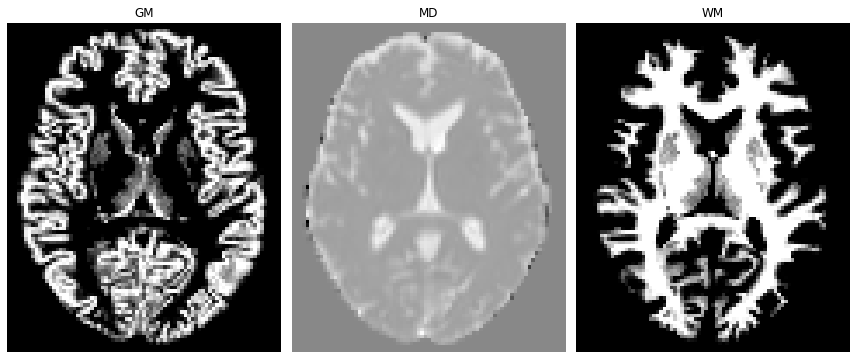

In [20]:
train_loader, val_loader = load_data(train_data_path, modalities, additional_variables, batch_size, False)

tr = first(train_loader)
print('Data shape for training:')
for key, value in tr.items():
    print(f'{key}: {list(value.shape)} \u00D7 {len(train_loader)}')
vl = first(val_loader)
print('\nData shape for validation:')
for key, value in vl.items():
    print(f'{key}: {list(value.shape)} \u00D7 {len(val_loader)}')

_, axs = plt.subplots(1, len(modalities), figsize=(len(modalities) * 4, 5))
for i, key in enumerate(modalities):
    image = tr[key][0, 0, :, :, :]
    if isinstance(image, torch.Tensor):
        image = image.numpy()
    middle_index = image.shape[2] // 2
    slice_2d = np.squeeze(image[:, :, middle_index])
    ax = axs[i]
    ax.imshow(np.rot90(slice_2d), cmap='gray')
    ax.set_title(key)
    ax.axis('off')
plt.tight_layout()
plt.show()

### Train Model

Best accuracy: 0.000 at epoch 1; Total time consumed: 0.17 mins


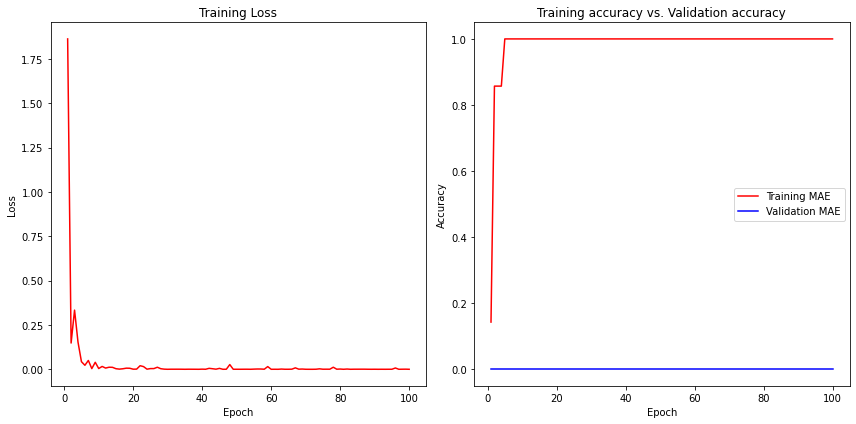

In [21]:
model, epoch_loss_values, epoch_metric_values, metric_values = train_model(model_path, device, train_loader, val_loader,
    modalities, additional_variables, logger, criterion, max_epochs, learning_rate, weight_decay, val_interval)
plot_metric_values(model_path, epoch_loss_values, epoch_metric_values, metric_values, val_interval)

### Inference

In [22]:
test_loader = load_data(test_data_path, modalities, additional_variables, batch_size, True)
apply_best_model(model_path, model, device, test_loader, modalities, additional_variables)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /mnt/hdd/eric/.conda/envs/8.tmp.copied/lib/python3.8/site-packages/nibabel/loadsave.py:100 in    │
│ load                                                                                             │
│                                                                                                  │
│    97 │                                                                                          │
│    98 │   # Check file exists and is not empty                                                   │
│    99 │   try:                                                                                   │
│ ❱ 100 │   │   stat_result = os.stat(filename)                                                    │
│   101 │   except OSError:                                                                        │
│   102 │   │   raise FileNotFoundError(f"No such file or no access: '{filename}'")                │
│   103 │   if stat_result.st_size <= 0:                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileNotFoundError: [Errno 2] No such file or directory: 
'/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/jw/dt/data/images/test/GM/010.nii.gz'

During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /mnt/hdd/eric/.conda/envs/8.tmp.copied/lib/python3.8/site-packages/monai/transforms/transform.py │
│ :141 in apply_transform                                                                          │
│                                                                                                  │
│   138 │   try:                                                                                   │
│   139 │   │   if isinstance(data, (list, tuple)) and map_items:                                  │
│   140 │   │   │   return [_apply_transform(transform, item, unpack_items, lazy, overrides, log   │
│ ❱ 141 │   │   return _apply_transform(transform, data, unpack_items, lazy, overrides, log_stat   │
│   142 │   except Exception as e:                                                                 │
│   143 │   │   # if in debug mode, don't swallow exception so that the breakpoint                 │
│   144 │   │   # appears where the exception was raised.                                          │
│                                                                                                  │
│ /mnt/hdd/eric/.conda/envs/8.tmp.copied/lib/python3.8/site-packages/monai/transforms/transform.py │
│ :98 in _apply_transform                                                                          │
│                                                                                                  │
│    95 │   if isinstance(data, tuple) and unpack_parameters:                                      │
│    96 │   │   return transform(*data, lazy=lazy) if isinstance(transform, LazyTrait) else tran   │
│    97 │                                                                                          │
│ ❱  98 │   return transform(data, lazy=lazy) if isinstance(transform, LazyTrait) else transform   │
│    99                                                                                            │
│   100                                                                                            │
│   101 def apply_transform(                                                                       │
│                                                                                                  │
│ /mnt/hdd/eric/.conda/envs/8.tmp.copied/lib/python3.8/site-packages/monai/transforms/io/dictionar │
│ y.py:162 in __call__                                                                             │
│                                           

### SHAP (SHapley Additive exPlanations)

In [ ]:
# Initialize SHAP GradientExplainer with training data

# train_images_list = []
# train_variables_list = []
# for train_batch_data in train_loader:
#     train_images = [train_batch_data[modality].to(device) for modality in modalities]
#     train_image_inputs = torch.cat(train_images, dim=1)
#     train_variables = [train_batch_data[variable].view(-1,1).to(device) for variable in additional_variables if variable != 'Sex']
#     train_variable_inputs = torch.cat(train_variables, dim=1)
#     train_images_list.append(train_image_inputs)
#     train_variables_list.append(train_variable_inputs)
# train_images_list = torch.cat(train_images_list, dim=0)
# train_variables_list = torch.cat(train_variables_list, dim=0)
# explainer = shap.GradientExplainer(model, [train_images_list, train_variables_list])

train_batch_data = first(train_loader)
train_images = [train_batch_data[modality].to(device) for modality in modalities]
train_image_inputs = torch.cat(train_images, dim=1)
train_variables = [train_batch_data[variable].view(-1,1).to(device) for variable in additional_variables if variable != 'Sex']
train_variable_inputs = torch.cat(train_variables, dim=1)
explainer = shap.GradientExplainer(model, [train_image_inputs, train_variable_inputs])

# Compute SHAP values for validation data
image_shap_values_list = []
variable_shap_values_list = []
val_images_list = []
val_variables_list = []
for val_batch_data in val_loader:
    val_images = [val_batch_data[modality].to(device) for modality in modalities]
    val_image_inputs = torch.cat(val_images, dim=1)
    val_variables = [val_batch_data[variable].view(-1,1).to(device) for variable in additional_variables if variable != 'Sex']
    val_variable_inputs = torch.cat(val_variables, dim=1)
    shap_values = explainer.shap_values([val_image_inputs, val_variable_inputs])
    image_shap_values_list.append(shap_values[0])
    variable_shap_values_list.append(shap_values[1])
    val_images_list.append(val_image_inputs.cpu().numpy())
    val_variables_list.append(val_variable_inputs.cpu().numpy())
image_shap_values_list = np.concatenate(image_shap_values_list, axis=0)
variable_shap_values_list = np.concatenate(variable_shap_values_list, axis=0)
val_images_list = np.concatenate(val_images_list, axis=0)
val_variables_list = np.concatenate(val_variables_list, axis=0)

**Plot SHAP values for images**

In [ ]:
_, axs = plt.subplots(len(modalities), 1, figsize=(12, len(modalities) * 4))
for i, key in enumerate(modalities):
    mean_abs_shap_values = np.mean(np.abs(image_shap_values_list[:, i, :, :, :, 1]), axis=0)
    mean_images = np.mean(val_images_list[:, i, :, :, :], axis=0)
    shap_values_img = nib.Nifti1Image(mean_abs_shap_values, np.eye(4))
    thresholded_shap_values_img = nli.threshold_img(shap_values_img, threshold='95%', cluster_threshold=10)
    map_img = nib.Nifti1Image(mean_images, np.eye(4))
    plotting.plot_stat_map(thresholded_shap_values_img, bg_img=map_img, axes=axs[i], title=key, cmap="magma", symmetric_cbar=False)
    nib.save(shap_values_img, os.path.join(model_path, "SHAPValues_" + key + ".nii.gz"))
plt.tight_layout()
plt.show()

**Plot SHAP values for additional variables**

In [ ]:
feature_names = [variable for variable in additional_variables if variable != 'Sex']
shap.summary_plot(variable_shap_values_list[:, :, 1], val_variables_list, feature_names)